In [30]:
!pip install torch torchvision


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Set some parameters
batch_size = 128
epochs_per_task = 7
num_seeds = 1



Using device: cuda


In [33]:
# Choose one of: "mnist", "cifar10", "cifar100"
dataset_name = "cifar100"  # change this to "cifar10" or "cifar100" as needed

print(f"Loading dataset: {dataset_name}")

if dataset_name == "mnist":
    # MNIST: Single-channel, classes 0-9
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

    task_A_classes = [0,1,2,3,4]
    task_B_classes = [5,6,7,8,9]

elif dataset_name == "cifar10":
    # CIFAR-10: 3-channel, classes 0-9
    cifar10_mean = (0.4914, 0.4822, 0.4465)
    cifar10_std = (0.2023, 0.1994, 0.2010)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(cifar10_mean, cifar10_std)
    ])
    train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

    task_A_classes = [0,1,2,3,4]
    task_B_classes = [5,6,7,8,9]

elif dataset_name == "cifar100":
    # CIFAR-100: 3-channel, classes 0-99
    cifar100_mean = (0.5071, 0.4865, 0.4409)
    cifar100_std = (0.2673, 0.2564, 0.2762)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(cifar100_mean, cifar100_std)
    ])
    train_dataset = torchvision.datasets.CIFAR100(root="./data", train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.CIFAR100(root="./data", train=False, download=True, transform=transform)

    # Example split for CIFAR-100: first 50 classes for Task A, next 50 for Task B
    task_A_classes = list(range(50))
    task_B_classes = list(range(50, 100))

elif dataset_name == "cifar100_1":
    # CIFAR-100 is arranged into 20 supercategories (coarse labels), each containing 5 classes (fine labels).
    # Each supercategory groups classes that share a high-level semantic theme.
    #
    # We choose 5 distinct supercategories and assign classes to Task A and Task B as per your requested pattern:
    # 1) One supercategory with a (2,2) split
    # 2) One supercategory with a (1,0) split
    # 3) One supercategory with a (0,1) split
    # 4) One supercategory with a (1,4) split
    # 5) One supercategory with a (4,1) split
    #
    # Chosen supercategories and their classes (taken from CIFAR-100’s known 100 classes, alphabetically sorted):
    #
    # Supercategory: aquatic_mammals (2,2 split)
    # Classes: beaver(4), dolphin(30), otter(55), seal(72), whale(95)
    # A=[4,30], B=[55,72] (We leave out 95)
    #
    # Supercategory: fish (1,0 split)
    # Classes: aquarium_fish(1), flatfish(32), ray(67), shark(73), trout(91)
    # A=[1], B=[]
    #
    # Supercategory: flowers (0,1 split)
    # Classes: orchid(54), poppy(62), rose(70), sunflower(82), tulip(92)
    # A=[], B=[54] (We ignore the others)
    #
    # Supercategory: household_furniture (1,4 split)
    # Classes: bed(5), chair(20), couch(25), table(84), wardrobe(94)
    # A=[20], B=[5,25,84,94]
    #
    # Supercategory: large_man-made_outdoor_things (4,1 split)
    # Classes: bridge(12), castle(17), house(37), road(68), skyscraper(76)
    # A=[12,17,37,68], B=[76]

    # Combine all chosen classes for Task A:
    # A from aquatic_mammals: [4,30]
    # A from fish: [1]
    # A from flowers: []
    # A from household_furniture: [20]
    # A from large_man-made_outdoor_things: [12,17,37,68]
    # Total A = [1,4,12,17,20,30,37,68]

    # Combine all chosen classes for Task B:
    # B from aquatic_mammals: [55,72]
    # B from fish: []
    # B from flowers: [54]
    # B from household_furniture: [5,25,84,94]
    # B from large_man-made_outdoor_things: [76]
    # Total B = [5,25,54,55,72,76,84,94]

    task_A_classes = [1,4,12,17,20,30,37,68]
    task_B_classes = [5,25,54,55,72,76,84,94]

    # Normalization for CIFAR-100
    cifar100_mean = (0.5071, 0.4865, 0.4409)
    cifar100_std = (0.2673, 0.2564, 0.2762)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(cifar100_mean, cifar100_std)
    ])
    train_dataset = torchvision.datasets.CIFAR100(root="./data", train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.CIFAR100(root="./data", train=False, download=True, transform=transform)

else:
    raise ValueError("Unknown dataset name")

def get_class_indices(dataset, classes):
    return [i for i, (x,y) in enumerate(dataset) if y in classes]

print("Splitting dataset into Task A and Task B...")

train_indices_A = get_class_indices(train_dataset, task_A_classes)
train_indices_B = get_class_indices(train_dataset, task_B_classes)

test_indices_A = get_class_indices(test_dataset, task_A_classes)
test_indices_B = get_class_indices(test_dataset, task_B_classes)

train_loader_A = DataLoader(Subset(train_dataset, train_indices_A), batch_size=batch_size, shuffle=True)
train_loader_B = DataLoader(Subset(train_dataset, train_indices_B), batch_size=batch_size, shuffle=True)

test_loader_A = DataLoader(Subset(test_dataset, test_indices_A), batch_size=batch_size, shuffle=False)
test_loader_B = DataLoader(Subset(test_dataset, test_indices_B), batch_size=batch_size, shuffle=False)

print("Data loaders are ready.")


Loading dataset: cifar100
Files already downloaded and verified
Files already downloaded and verified
Splitting dataset into Task A and Task B...
Data loaders are ready.


In [34]:
# Define model depending on the dataset
# For MNIST: single-channel input (1x28x28)
# For CIFAR: 3-channel input (3x32x32)
# Adjust architecture as needed.

if dataset_name == "mnist":
    # Simple model for MNIST
    class SimpleCNN(nn.Module):
        def __init__(self, num_classes=10):
            super(SimpleCNN, self).__init__()
            self.conv1 = nn.Conv2d(1, 16, 3, 1)  # 1 channel in
            self.conv2 = nn.Conv2d(16, 32, 3, 1)
            self.fc1 = nn.Linear(32*24*24, 100)
            self.fc2 = nn.Linear(100, num_classes)
        def forward(self, x, return_intermediate=False):
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            embedding = F.relu(self.fc1(x))
            out = self.fc2(embedding)
            if return_intermediate:
                return out, embedding
            return out

elif dataset_name == "cifar10":
    # Simple model for CIFAR-10
    class SimpleCNN(nn.Module):
        def __init__(self, num_classes=10):
            super(SimpleCNN, self).__init__()
            self.conv1 = nn.Conv2d(3, 32, 3, 1) # 3 channels for CIFAR
            self.conv2 = nn.Conv2d(32, 64, 3, 1)
            self.pool = nn.MaxPool2d(2,2)
            self.conv3 = nn.Conv2d(64, 128, 3, 1)
            self.pool2 = nn.MaxPool2d(2,2)
            self.fc1 = nn.Linear(128*6*6, 256)  # 32x32 -> after two pools -> 8x8, minus padding from conv
            self.fc2 = nn.Linear(256, num_classes)
        def forward(self, x, return_intermediate=False):
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = self.pool(x)
            x = F.relu(self.conv3(x))
            x = self.pool2(x)
            x = x.view(x.size(0), -1)
            embedding = F.relu(self.fc1(x))
            out = self.fc2(embedding)
            if return_intermediate:
                return out, embedding
            return out

elif dataset_name == "cifar100":
    # Simple model for CIFAR-100
    # Same architecture as CIFAR-10, but num_classes = 100
  class SimpleCNN(nn.Module):
    def __init__(self, num_classes=100):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.pool2 = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(128*6*6, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_classes)  # final output layer

    def forward(self, x, return_intermediate=False):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        embedding = F.relu(self.fc3(x))
        out = self.fc4(embedding)

        if return_intermediate:
            return out, embedding
        return out
else:
  # Simple model for CIFAR-100
    # Same architecture as CIFAR-10, but num_classes = 100

  class SimpleCNN(nn.Module):
    def __init__(self, num_classes=100):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.pool2 = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(128*6*6, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_classes)  # final output layer

    def forward(self, x, return_intermediate=False):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        embedding = F.relu(self.fc3(x))
        out = self.fc4(embedding)

        if return_intermediate:
            return out, embedding
        return out


print("Model class defined for:", dataset_name)


Model class defined for: cifar100


In [35]:
def train_model(model, loader, optimizer, criterion, epochs=1, verbose=True):
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        total_correct = 0
        total_samples = 0

        pbar = tqdm(loader, desc=f"Training Epoch {epoch+1}/{epochs}", leave=False)

        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x.size(0)
            preds = out.argmax(dim=1)
            total_correct += (preds == y).sum().item()
            total_samples += y.size(0)

            if verbose:
                pbar.set_postfix({
                    "Loss": f"{loss.item():.4f}",
                    "Acc": f"{100 * total_correct/total_samples:.2f}%"
                })

        epoch_loss = total_loss / total_samples
        epoch_acc = total_correct / total_samples
        print(f"  -> Epoch {epoch+1}/{epochs} done. Loss: {epoch_loss:.4f}, Acc: {epoch_acc*100:.2f}%")

def evaluate_model(model, loader, verbose=True):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    acc = correct / total
    if verbose:
        print(f"Evaluation: Accuracy = {acc*100:.2f}%")
    return acc


In [36]:
print("\nStarting Probing Experiment (Multi-Seed with per-class breakdown and summary statistics)...")

# Define class names based on the dataset
if dataset_name == "mnist":
    class_names_full = [str(i) for i in range(10)]
elif dataset_name == "cifar10":
    class_names_full = ['airplane','automobile','bird','cat','deer',
                        'dog','frog','horse','ship','truck']
elif dataset_name == "cifar100" or dataset_name == "cifar100_1":
    # CIFAR-100 classes are alphabetically ordered in train_dataset.classes
    class_names_full = train_dataset.classes
else:
    # Fallback in case of an unknown dataset
    class_names_full = [f"Class_{i}" for i in range(max(task_A_classes+task_B_classes)+1)]

def evaluate_model_per_class(model, loader, classes=[0,1,2,3,4], verbose=True):
    model.eval()
    class_correct = {c: 0 for c in classes}
    class_total = {c: 0 for c in classes}

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = out.argmax(dim=1)
            for c in classes:
                class_mask = (y == c)
                class_correct[c] += (preds[class_mask] == c).sum().item()
                class_total[c] += class_mask.sum().item()

    total_correct = sum(class_correct.values())
    total_samples = sum(class_total.values())
    total_accuracy = total_correct / total_samples if total_samples > 0 else 0.0

    class_accuracies = {}
    if verbose:
        print(f"Overall Accuracy: {total_accuracy*100:.2f}%")
    for c in classes:
        if class_total[c] > 0:
            class_accuracies[c] = class_correct[c] / class_total[c]
        else:
            class_accuracies[c] = 0.0
        if verbose:
            class_name = class_names_full[c] if c < len(class_names_full) else f"Class_{c}"
            print(f"  Class {c} ({class_name}): {class_accuracies[c]*100:.2f}%")

    return total_accuracy, class_accuracies

def probe_model(freeze_up_to_layer="conv1", model_state=None, randomize=False, sequential=False):
    """
    Probe model for both sequential and non-sequential cases
    Args:
        freeze_up_to_layer: Which layer to freeze up to
        model_state: Model state dict to load
        randomize: Whether to use random initialization
        sequential: Whether we're in sequential mode (using tasks) or non-sequential (using task_A_classes)
    """
    num_classes = len(class_names_full)
    probed_model = SimpleCNN(num_classes=num_classes).to(device)

    if not randomize:
        missing = probed_model.load_state_dict(model_state, strict=False)

    def reinit(module):
        if hasattr(module, 'reset_parameters'):
            module.reset_parameters()

    # Freeze layers and re-init subsequent layers
    if freeze_up_to_layer == "conv1":
        for p in probed_model.conv1.parameters():
            p.requires_grad = False
        probed_model.conv2.apply(reinit)
        probed_model.conv3.apply(reinit)
        probed_model.fc1.apply(reinit)
        probed_model.fc2.apply(reinit)
        probed_model.fc3.apply(reinit)
        probed_model.fc4.apply(reinit)

    elif freeze_up_to_layer == "conv2":
        for p in probed_model.conv1.parameters():
            p.requires_grad = False
        for p in probed_model.conv2.parameters():
            p.requires_grad = False
        probed_model.conv3.apply(reinit)
        probed_model.fc1.apply(reinit)
        probed_model.fc2.apply(reinit)
        probed_model.fc3.apply(reinit)
        probed_model.fc4.apply(reinit)

    elif freeze_up_to_layer == "conv3":
        for p in probed_model.conv1.parameters():
            p.requires_grad = False
        for p in probed_model.conv2.parameters():
            p.requires_grad = False
        for p in probed_model.conv3.parameters():
            p.requires_grad = False
        probed_model.fc1.apply(reinit)
        probed_model.fc2.apply(reinit)
        probed_model.fc3.apply(reinit)
        probed_model.fc4.apply(reinit)

    elif freeze_up_to_layer == "fc1":
        for p in probed_model.conv1.parameters():
            p.requires_grad = False
        for p in probed_model.conv2.parameters():
            p.requires_grad = False
        for p in probed_model.conv3.parameters():
            p.requires_grad = False
        for p in probed_model.fc1.parameters():
            p.requires_grad = False
        probed_model.fc2.apply(reinit)
        probed_model.fc3.apply(reinit)
        probed_model.fc4.apply(reinit)

    elif freeze_up_to_layer == "fc2":
        for p in probed_model.conv1.parameters():
            p.requires_grad = False
        for p in probed_model.conv2.parameters():
            p.requires_grad = False
        for p in probed_model.conv3.parameters():
            p.requires_grad = False
        for p in probed_model.fc1.parameters():
            p.requires_grad = False
        for p in probed_model.fc2.parameters():
            p.requires_grad = False
        probed_model.fc3.apply(reinit)
        probed_model.fc4.apply(reinit)

    elif freeze_up_to_layer == "fc3":
        for p in probed_model.conv1.parameters():
            p.requires_grad = False
        for p in probed_model.conv2.parameters():
            p.requires_grad = False
        for p in probed_model.conv3.parameters():
            p.requires_grad = False
        for p in probed_model.fc1.parameters():
            p.requires_grad = False
        for p in probed_model.fc2.parameters():
            p.requires_grad = False
        for p in probed_model.fc3.parameters():
            p.requires_grad = False
        probed_model.fc4.apply(reinit)

    else:
        raise ValueError(f"Unknown freeze_up_to_layer: {freeze_up_to_layer}")

    # Create appropriate train and test loaders based on mode
    if sequential:
        # Sequential mode: use all classes from all tasks
        all_classes = [c for task in tasks for c in task]
        train_indices = get_class_indices(train_dataset, all_classes)
        test_indices = get_class_indices(test_dataset, all_classes)
    else:
        # Non-sequential mode: use task_A_classes
        train_indices = get_class_indices(train_dataset, task_A_classes)
        test_indices = get_class_indices(test_dataset, task_A_classes)

    train_loader = DataLoader(
        Subset(train_dataset, train_indices),
        batch_size=batch_size,
        shuffle=True
    )

    test_loader = DataLoader(
        Subset(test_dataset, test_indices),
        batch_size=batch_size,
        shuffle=False
    )

    # Train
    opt = optim.Adam(filter(lambda p: p.requires_grad, probed_model.parameters()), lr=0.001)
    train_model(probed_model, train_loader, opt, nn.CrossEntropyLoss(),
                epochs=epochs_per_task, verbose=True)

    # Evaluate
    print("Evaluating probed model (Overall + Per-Class):")
    if sequential:
        classes_to_evaluate = all_classes
    else:
        classes_to_evaluate = task_A_classes

    overall_acc, class_accs = evaluate_model_per_class(probed_model, test_loader,
                                                     classes=classes_to_evaluate)
    return overall_acc, class_accs



Starting Probing Experiment (Multi-Seed with per-class breakdown and summary statistics)...


In [44]:
not_sequnetial = True
if not_sequnetial:
  # Define dictionaries before training
  A_before_per_class = {c:[] for c in task_A_classes}
  A_after_per_class = {c:[] for c in task_A_classes}
  B_per_class = {c:[] for c in task_B_classes}
  accuracy_A_before_list = []
  accuracy_A_after_list = []
  accuracy_B_list = []

  # Run cyclical training
  do_cyclical = True
  num_cycles = 1 if do_cyclical else 1

  print("Starting Continual Learning Experiments...")
  print(f"Cyclical mode: {'Enabled' if do_cyclical else 'Disabled'}")
  print(f"Number of cycles: {num_cycles}")

  final_models_after_B=[]

  for seed in range(num_seeds):
      print(f"\n--- Seed {seed} ---")
      torch.manual_seed(seed)
      np.random.seed(seed)

      model=SimpleCNN(num_classes=len(class_names_full)).to(device)
      optimizer=optim.Adam(model.parameters(), lr=0.001)
      criterion=nn.CrossEntropyLoss()

      for cycle in range(num_cycles):
          # Train A
          print("Training on Task A (classes:", task_A_classes, ")...")
          train_model(model, train_loader_A, optimizer, criterion, epochs=epochs_per_task, verbose=True)
          acc_A_before, class_accs_A_before = evaluate_model_per_class(model, test_loader_A, classes=task_A_classes, verbose=False)
          # Store A-before
          if cycle==0:
              accuracy_A_before_list.append(acc_A_before)
          for c in task_A_classes:
              A_before_per_class[c].append(class_accs_A_before[c])

          # Train B
          print("Training on Task B (classes:", task_B_classes, ")...")
          train_model(model, train_loader_B, optimizer, criterion, epochs=epochs_per_task, verbose=True)
          acc_A_after, class_accs_A_after = evaluate_model_per_class(model, test_loader_A, classes=task_A_classes, verbose=False)
          acc_B, class_accs_B = evaluate_model_per_class(model, test_loader_B, classes=task_B_classes, verbose=False)
          if cycle==num_cycles-1:
              accuracy_A_after_list.append(acc_A_after)
              accuracy_B_list.append(acc_B)
          for c in task_A_classes:
              A_after_per_class[c].append(class_accs_A_after[c])
          for c in task_B_classes:
              B_per_class[c].append(class_accs_B[c])

      final_state=model.state_dict()
      final_state_copy={k:v.cpu().clone() for k,v in final_state.items()}
      final_models_after_B.append(final_state_copy)

  print("\n----- Results Over All Seeds -----")
  avg_accuracy_A_before = np.mean(accuracy_A_before_list)
  std_accuracy_A_before = np.std(accuracy_A_before_list)
  avg_accuracy_A_after = np.mean(accuracy_A_after_list)
  std_accuracy_A_after = np.std(accuracy_A_after_list)
  avg_accuracy_B = np.mean(accuracy_B_list)
  std_accuracy_B = np.std(accuracy_B_list)
  forgetting = avg_accuracy_A_before - avg_accuracy_A_after

  print(f"Average Accuracy on Task A before second training: {avg_accuracy_A_before*100:.2f}% ± {std_accuracy_A_before*100:.2f}%")
  print(f"Average Accuracy on Task A after second training:  {avg_accuracy_A_after*100:.2f}% ± {std_accuracy_A_after*100:.2f}%")
  print(f"Average Accuracy on Task B after second training:   {avg_accuracy_B*100:.2f}% ± {std_accuracy_B*100:.2f}%")
  print(f"Forgetting (Task A): {forgetting*100:.2f}%")

  print("\nPer-Class Accuracies for Task A before training on B (Mean ± Std):")
  for c in task_A_classes:
      mean_c=np.mean(A_before_per_class[c])*100
      std_c=np.std(A_before_per_class[c])*100
      class_name=class_names_full[c] if c<len(class_names_full) else f"Class_{c}"
      print(f"  Class {c} ({class_name}): {mean_c:.2f}% ± {std_c:.2f}%")

  print("\nPer-Class Accuracies for Task A after training on B (Mean ± Std):")
  for c in task_A_classes:
      mean_c=np.mean(A_after_per_class[c])*100
      std_c=np.std(A_after_per_class[c])*100
      class_name=class_names_full[c] if c<len(class_names_full) else f"Class_{c}"
      print(f"  Class {c} ({class_name}): {mean_c:.2f}% ± {std_c:.2f}%")

  print("\nPer-Class Accuracies for Task B after training on B (Mean ± Std):")
  for c in task_B_classes:
      mean_c=np.mean(B_per_class[c])*100
      std_c=np.std(B_per_class[c])*100
      class_name=class_names_full[c] if c<len(class_names_full) else f"Class_{c}"
      print(f"  Class {c} ({class_name}): {mean_c:.2f}% ± {std_c:.2f}%")

Starting Continual Learning Experiments...
Cyclical mode: Enabled
Number of cycles: 1

--- Seed 0 ---
Training on Task A (classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49] )...


  -> Epoch 1/7 done. Loss: 3.6932, Acc: 8.16%


  -> Epoch 2/7 done. Loss: 3.1152, Acc: 19.53%


  -> Epoch 3/7 done. Loss: 2.7805, Acc: 26.82%


  -> Epoch 4/7 done. Loss: 2.4714, Acc: 33.90%


  -> Epoch 5/7 done. Loss: 2.2166, Acc: 39.72%


  -> Epoch 6/7 done. Loss: 2.0081, Acc: 44.38%


  -> Epoch 7/7 done. Loss: 1.8302, Acc: 48.73%
Training on Task B (classes: [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] )...


  -> Epoch 1/7 done. Loss: 3.7935, Acc: 6.91%


  -> Epoch 2/7 done. Loss: 3.1415, Acc: 15.20%


  -> Epoch 3/7 done. Loss: 2.9686, Acc: 18.24%


  -> Epoch 4/7 done. Loss: 2.8482, Acc: 20.52%


  -> Epoch 5/7 done. Loss: 2.6790, Acc: 24.53%


  -> Epoch 6/7 done. Loss: 2.5214, Acc: 27.64%


  -> Epoch 7/7 done. Loss: 2.4027, Acc: 30.45%

----- Results Over All Seeds -----
Average Accuracy on Task A before second training: 42.88% ± 0.00%
Average Accuracy on Task A after second training:  0.00% ± 0.00%
Average Accuracy on Task B after second training:   28.78% ± 0.00%
Forgetting (Task A): 42.88%

Per-Class Accuracies for Task A before training on B (Mean ± Std):
  Class 0 (apple): 70.00% ± 0.00%
  Class 1 (aquarium_fish): 67.00% ± 0.00%
  Class 2 (baby): 33.00% ± 0.00%
  Class 3 (bear): 16.00% ± 0.00%
  Class 4 (beaver): 16.00% ± 0.00%
  Class 5 (bed): 48.00% ± 0.00%
  Class 6 (bee): 42.00% ± 0.00%
  Class 7 (beetle): 34.00% ± 0.00%
  Class 8 (bicycle): 38.00% ± 0.00%
  Class 9 (bottle): 51.00% ± 0.00%
  Class 10 (bowl): 24.00% ± 0.00%
  Class 11 (boy): 21.00% ± 0.00%
  Class 12 (bridge): 42.00% ± 0.00%
  Class 13 (bus): 65.00% ± 0.00%
  Class 14 (butterfly): 35.00% ± 0.00%
  Class 15 (camel): 37.00% ± 0.00%
  Class 16 (can): 27.00% ± 0.00%
  Class 17 (castle): 77.00% ± 0.0

Running probing for each seed...

*** Probing for Seed 0 ***
Probing with freeze_up_to_layer = conv1 for seed 0


  -> Epoch 1/7 done. Loss: 3.5838, Acc: 10.19%


  -> Epoch 2/7 done. Loss: 2.9202, Acc: 23.30%


  -> Epoch 3/7 done. Loss: 2.5111, Acc: 32.44%


  -> Epoch 4/7 done. Loss: 2.1948, Acc: 39.93%


  -> Epoch 5/7 done. Loss: 1.9520, Acc: 45.95%


  -> Epoch 6/7 done. Loss: 1.7385, Acc: 50.96%


  -> Epoch 7/7 done. Loss: 1.5477, Acc: 55.67%
Evaluating probed model (Overall + Per-Class):
Overall Accuracy: 46.48%
  Class 0 (apple): 80.00%
  Class 1 (aquarium_fish): 69.00%
  Class 2 (baby): 16.00%
  Class 3 (bear): 16.00%
  Class 4 (beaver): 24.00%
  Class 5 (bed): 28.00%
  Class 6 (bee): 49.00%
  Class 7 (beetle): 57.00%
  Class 8 (bicycle): 62.00%
  Class 9 (bottle): 66.00%
  Class 10 (bowl): 33.00%
  Class 11 (boy): 22.00%
  Class 12 (bridge): 42.00%
  Class 13 (bus): 59.00%
  Class 14 (butterfly): 47.00%
  Class 15 (camel): 35.00%
  Class 16 (can): 29.00%
  Class 17 (castle): 68.00%
  Class 18 (caterpillar): 46.00%
  Class 19 (cattle): 32.00%
  Class 20 (chair): 72.00%
  Class 21 (chimpanzee): 66.00%
  Class 22 (clock): 44.00%
  Class 23 (cloud): 78.00%
  Class 24 (cockroach): 53.00%
  Class 25 (couch): 27.00%
  Class 26 (crab): 23.00%
  Class 27 (crocodile): 52.00%
  Class 28 (cup): 69.00%
  Class 29 (dinosaur): 42.00%
  Class 30 (dolphin): 71.00%
  Class 31 (elephant): 40.

  -> Epoch 1/7 done. Loss: 3.3634, Acc: 15.69%


  -> Epoch 2/7 done. Loss: 2.4333, Acc: 34.23%


  -> Epoch 3/7 done. Loss: 2.0516, Acc: 43.29%


  -> Epoch 4/7 done. Loss: 1.8214, Acc: 48.93%


  -> Epoch 5/7 done. Loss: 1.6114, Acc: 54.25%


  -> Epoch 6/7 done. Loss: 1.4224, Acc: 58.87%


  -> Epoch 7/7 done. Loss: 1.2229, Acc: 64.23%
Evaluating probed model (Overall + Per-Class):
Overall Accuracy: 50.20%
  Class 0 (apple): 80.00%
  Class 1 (aquarium_fish): 57.00%
  Class 2 (baby): 37.00%
  Class 3 (bear): 37.00%
  Class 4 (beaver): 28.00%
  Class 5 (bed): 51.00%
  Class 6 (bee): 56.00%
  Class 7 (beetle): 46.00%
  Class 8 (bicycle): 71.00%
  Class 9 (bottle): 74.00%
  Class 10 (bowl): 27.00%
  Class 11 (boy): 24.00%
  Class 12 (bridge): 50.00%
  Class 13 (bus): 63.00%
  Class 14 (butterfly): 29.00%
  Class 15 (camel): 32.00%
  Class 16 (can): 60.00%
  Class 17 (castle): 74.00%
  Class 18 (caterpillar): 47.00%
  Class 19 (cattle): 37.00%
  Class 20 (chair): 74.00%
  Class 21 (chimpanzee): 42.00%
  Class 22 (clock): 49.00%
  Class 23 (cloud): 80.00%
  Class 24 (cockroach): 81.00%
  Class 25 (couch): 26.00%
  Class 26 (crab): 43.00%
  Class 27 (crocodile): 39.00%
  Class 28 (cup): 76.00%
  Class 29 (dinosaur): 43.00%
  Class 30 (dolphin): 69.00%
  Class 31 (elephant): 33.

  -> Epoch 1/7 done. Loss: 3.2097, Acc: 18.79%


  -> Epoch 2/7 done. Loss: 2.4071, Acc: 35.40%


  -> Epoch 3/7 done. Loss: 2.1296, Acc: 41.14%


  -> Epoch 4/7 done. Loss: 1.9467, Acc: 45.86%


  -> Epoch 5/7 done. Loss: 1.8037, Acc: 49.42%


  -> Epoch 6/7 done. Loss: 1.6710, Acc: 52.65%


  -> Epoch 7/7 done. Loss: 1.5575, Acc: 55.73%
Evaluating probed model (Overall + Per-Class):
Overall Accuracy: 44.52%
  Class 0 (apple): 63.00%
  Class 1 (aquarium_fish): 76.00%
  Class 2 (baby): 15.00%
  Class 3 (bear): 25.00%
  Class 4 (beaver): 27.00%
  Class 5 (bed): 46.00%
  Class 6 (bee): 38.00%
  Class 7 (beetle): 39.00%
  Class 8 (bicycle): 43.00%
  Class 9 (bottle): 55.00%
  Class 10 (bowl): 39.00%
  Class 11 (boy): 22.00%
  Class 12 (bridge): 62.00%
  Class 13 (bus): 61.00%
  Class 14 (butterfly): 45.00%
  Class 15 (camel): 19.00%
  Class 16 (can): 53.00%
  Class 17 (castle): 52.00%
  Class 18 (caterpillar): 48.00%
  Class 19 (cattle): 33.00%
  Class 20 (chair): 65.00%
  Class 21 (chimpanzee): 69.00%
  Class 22 (clock): 35.00%
  Class 23 (cloud): 82.00%
  Class 24 (cockroach): 72.00%
  Class 25 (couch): 34.00%
  Class 26 (crab): 52.00%
  Class 27 (crocodile): 56.00%
  Class 28 (cup): 55.00%
  Class 29 (dinosaur): 17.00%
  Class 30 (dolphin): 74.00%
  Class 31 (elephant): 20.

  -> Epoch 1/7 done. Loss: 3.4208, Acc: 13.39%


  -> Epoch 2/7 done. Loss: 3.0848, Acc: 18.71%


  -> Epoch 3/7 done. Loss: 3.0370, Acc: 19.90%


  -> Epoch 4/7 done. Loss: 3.0149, Acc: 20.25%


  -> Epoch 5/7 done. Loss: 2.9845, Acc: 21.11%


  -> Epoch 6/7 done. Loss: 2.9720, Acc: 21.18%


  -> Epoch 7/7 done. Loss: 2.9615, Acc: 21.31%
Evaluating probed model (Overall + Per-Class):
Overall Accuracy: 21.80%
  Class 0 (apple): 67.00%
  Class 1 (aquarium_fish): 27.00%
  Class 2 (baby): 8.00%
  Class 3 (bear): 7.00%
  Class 4 (beaver): 0.00%
  Class 5 (bed): 18.00%
  Class 6 (bee): 20.00%
  Class 7 (beetle): 3.00%
  Class 8 (bicycle): 3.00%
  Class 9 (bottle): 35.00%
  Class 10 (bowl): 22.00%
  Class 11 (boy): 5.00%
  Class 12 (bridge): 35.00%
  Class 13 (bus): 40.00%
  Class 14 (butterfly): 12.00%
  Class 15 (camel): 3.00%
  Class 16 (can): 6.00%
  Class 17 (castle): 55.00%
  Class 18 (caterpillar): 28.00%
  Class 19 (cattle): 4.00%
  Class 20 (chair): 22.00%
  Class 21 (chimpanzee): 10.00%
  Class 22 (clock): 17.00%
  Class 23 (cloud): 72.00%
  Class 24 (cockroach): 22.00%
  Class 25 (couch): 0.00%
  Class 26 (crab): 6.00%
  Class 27 (crocodile): 32.00%
  Class 28 (cup): 6.00%
  Class 29 (dinosaur): 0.00%
  Class 30 (dolphin): 60.00%
  Class 31 (elephant): 26.00%
  Class 3

  -> Epoch 1/7 done. Loss: 3.3688, Acc: 14.49%


  -> Epoch 2/7 done. Loss: 3.0720, Acc: 18.78%


  -> Epoch 3/7 done. Loss: 3.0361, Acc: 19.59%


  -> Epoch 4/7 done. Loss: 3.0135, Acc: 20.25%


  -> Epoch 5/7 done. Loss: 2.9976, Acc: 20.45%


  -> Epoch 6/7 done. Loss: 2.9790, Acc: 21.01%


  -> Epoch 7/7 done. Loss: 2.9704, Acc: 21.11%
Evaluating probed model (Overall + Per-Class):
Overall Accuracy: 21.64%
  Class 0 (apple): 65.00%
  Class 1 (aquarium_fish): 36.00%
  Class 2 (baby): 30.00%
  Class 3 (bear): 12.00%
  Class 4 (beaver): 0.00%
  Class 5 (bed): 8.00%
  Class 6 (bee): 29.00%
  Class 7 (beetle): 3.00%
  Class 8 (bicycle): 0.00%
  Class 9 (bottle): 32.00%
  Class 10 (bowl): 4.00%
  Class 11 (boy): 0.00%
  Class 12 (bridge): 36.00%
  Class 13 (bus): 40.00%
  Class 14 (butterfly): 11.00%
  Class 15 (camel): 0.00%
  Class 16 (can): 2.00%
  Class 17 (castle): 56.00%
  Class 18 (caterpillar): 34.00%
  Class 19 (cattle): 5.00%
  Class 20 (chair): 27.00%
  Class 21 (chimpanzee): 11.00%
  Class 22 (clock): 29.00%
  Class 23 (cloud): 65.00%
  Class 24 (cockroach): 16.00%
  Class 25 (couch): 2.00%
  Class 26 (crab): 12.00%
  Class 27 (crocodile): 11.00%
  Class 28 (cup): 9.00%
  Class 29 (dinosaur): 0.00%
  Class 30 (dolphin): 69.00%
  Class 31 (elephant): 21.00%
  Class 

  -> Epoch 1/7 done. Loss: 3.8186, Acc: 9.69%


  -> Epoch 2/7 done. Loss: 3.1750, Acc: 17.50%


  -> Epoch 3/7 done. Loss: 3.0986, Acc: 18.60%


  -> Epoch 4/7 done. Loss: 3.0717, Acc: 19.27%


  -> Epoch 5/7 done. Loss: 3.0569, Acc: 19.45%


  -> Epoch 6/7 done. Loss: 3.0448, Acc: 19.68%


  -> Epoch 7/7 done. Loss: 3.0369, Acc: 19.94%
Evaluating probed model (Overall + Per-Class):
Overall Accuracy: 19.84%
  Class 0 (apple): 68.00%
  Class 1 (aquarium_fish): 28.00%
  Class 2 (baby): 0.00%
  Class 3 (bear): 6.00%
  Class 4 (beaver): 1.00%
  Class 5 (bed): 7.00%
  Class 6 (bee): 33.00%
  Class 7 (beetle): 2.00%
  Class 8 (bicycle): 0.00%
  Class 9 (bottle): 16.00%
  Class 10 (bowl): 8.00%
  Class 11 (boy): 5.00%
  Class 12 (bridge): 32.00%
  Class 13 (bus): 45.00%
  Class 14 (butterfly): 6.00%
  Class 15 (camel): 2.00%
  Class 16 (can): 12.00%
  Class 17 (castle): 53.00%
  Class 18 (caterpillar): 13.00%
  Class 19 (cattle): 8.00%
  Class 20 (chair): 23.00%
  Class 21 (chimpanzee): 18.00%
  Class 22 (clock): 31.00%
  Class 23 (cloud): 63.00%
  Class 24 (cockroach): 12.00%
  Class 25 (couch): 2.00%
  Class 26 (crab): 13.00%
  Class 27 (crocodile): 14.00%
  Class 28 (cup): 5.00%
  Class 29 (dinosaur): 0.00%
  Class 30 (dolphin): 73.00%
  Class 31 (elephant): 25.00%
  Class 32

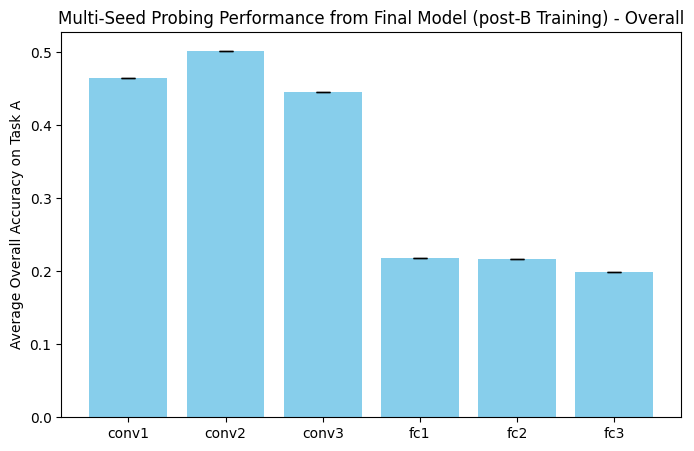

In [45]:
if not_sequnetial:
  if dataset_name == "mnist":
      freeze_points=["conv1","conv2","fc1"]
  elif dataset_name in ["cifar10"]:
      freeze_points=["conv1","conv2","fc1"]

  elif dataset_name == "cifar100":
      freeze_points=["conv1","conv2","conv3","fc1","fc2","fc3"]
  else:
      freeze_points=["conv1","conv2","conv3","fc1","fc2","fc3"]

  probe_results={fp:[] for fp in freeze_points}
  per_class_results={fp:{c:[] for c in task_A_classes} for fp in freeze_points}

  print("Running probing for each seed...")
  for seed in range(num_seeds):
      print(f"\n*** Probing for Seed {seed} ***")
      model_state=final_models_after_B[seed]
      for fp in freeze_points:
          print(f"Probing with freeze_up_to_layer = {fp} for seed {seed}")
          overall_acc, class_accs = overall_acc, class_accs = probe_model(freeze_up_to_layer=fp, model_state=model_state, randomize=False, sequential=False) # set to true or false
          probe_results[fp].append(overall_acc)
          for c in task_A_classes:
              per_class_results[fp][c].append(class_accs[c])

  avg_probe_accuracies={fp:np.mean(probe_results[fp]) for fp in freeze_points}
  std_probe_accuracies={fp:np.std(probe_results[fp]) for fp in freeze_points}

  avg_per_class_accuracies={}
  std_per_class_accuracies={}
  for fp in freeze_points:
      avg_per_class_accuracies[fp]={c:np.mean(per_class_results[fp][c]) for c in task_A_classes}
      std_per_class_accuracies[fp]={c:np.std(per_class_results[fp][c]) for c in task_A_classes}

  print("\nMulti-Seed Probing results (Mean ± Std):")
  for fp in freeze_points:
      print(f"\n=== Frozen up to {fp} ===")
      probe_overall_mean=avg_probe_accuracies[fp]*100
      probe_overall_std=std_probe_accuracies[fp]*100
      print(f"  Overall Accuracy (Mean ± Std): {probe_overall_mean:.2f}% ± {probe_overall_std:.2f}%")

      diff_from_A_before=(avg_probe_accuracies[fp]-avg_accuracy_A_before)*100
      diff_from_A_after=(avg_probe_accuracies[fp]-avg_accuracy_A_after)*100
      print(f"  Difference from A-before-B: {diff_from_A_before:.2f}%")

      for c in task_A_classes:
          mean_c=avg_per_class_accuracies[fp][c]*100
          std_c=std_per_class_accuracies[fp][c]*100
          class_name=class_names_full[c] if c<len(class_names_full) else f"Class_{c}"
          diff_class_from_A_before=(avg_per_class_accuracies[fp][c]-np.mean(A_before_per_class[c]))*100
          # diff_class_from_A_after=(avg_per_class_accuracies[fp][c]-np.mean(A_after_per_class[c]))*100
          print(f"    Class {c} ({class_name}): {mean_c:.2f}% ± {std_c:.2f}%")
          print(f"      Diff from A-before-B: {diff_class_from_A_before:.2f}%")

  print("\nTask B Classes:")
  for c in task_B_classes:
      class_name=class_names_full[c] if c<len(class_names_full) else f"Class_{c}"
      print(f"  Class {c} ({class_name})")

  plt.figure(figsize=(8,5))
  avg_accuracies=[avg_probe_accuracies[fp] for fp in freeze_points]
  std_accuracies=[std_probe_accuracies[fp] for fp in freeze_points]
  plt.bar(freeze_points, avg_accuracies, yerr=std_accuracies, color='skyblue', capsize=5)
  plt.ylabel('Average Overall Accuracy on Task A')
  plt.title('Multi-Seed Probing Performance from Final Model (post-B Training) - Overall')
  plt.show()

In [39]:
# Cell 1: Task and DataLoader Setup
# Run this cell once to set up the tasks and create dataloaders
tasks = [
    list(range(0, 10)),    # Classes 0-9
    list(range(10, 20)),   # Classes 10-19
    list(range(20, 30)),   # Classes 20-29
    list(range(30, 40)),   # Classes 30-39
    list(range(40, 50)),   # Classes 40-49
    list(range(50, 60)),   # Classes 50-59
    list(range(60, 70)),   # Classes 60-69
    list(range(70, 80)),   # Classes 70-79
    list(range(80, 90)),   # Classes 80-89
    list(range(90, 100))   # Classes 90-99
]

# To use single-class tasks instead, uncomment this:
# tasks = [[i] for i in range(100)]

def get_sequential_dataloaders(tasks):
    """Create data loaders for each task"""
    train_loaders = []
    test_loaders = []

    for task_classes in tasks:
        train_indices = get_class_indices(train_dataset, task_classes)
        test_indices = get_class_indices(test_dataset, task_classes)

        train_loader = DataLoader(
            Subset(train_dataset, train_indices),
            batch_size=batch_size,
            shuffle=True
        )
        test_loader = DataLoader(
            Subset(test_dataset, test_indices),
            batch_size=batch_size,
            shuffle=False
        )

        train_loaders.append(train_loader)
        test_loaders.append(test_loader)

    return train_loaders, test_loaders

# Create the dataloaders
train_loaders, test_loaders = get_sequential_dataloaders(tasks)
print("Dataloaders created for", len(tasks), "tasks")

Dataloaders created for 10 tasks


In [40]:
# Cell 2: Training and Analysis Functions
def sequential_training(train_loaders, test_loaders, tasks, num_seeds=1, epochs_per_task=7):
    """Train sequentially on multiple tasks and store results"""
    results = {
        'accuracies_during_training': [],  # Accuracies after each task
        'final_models': [],                # Final model states
        'per_task_per_class': {}          # Per-class accuracies for each task
    }

    for task_idx in range(len(tasks)):
        results['per_task_per_class'][task_idx] = {c: [] for c in tasks[task_idx]}

    for seed in range(num_seeds):
        print(f"\n=== Seed {seed} ===")
        torch.manual_seed(seed)
        np.random.seed(seed)

        # Initialize model
        model = SimpleCNN(num_classes=len(class_names_full)).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        # Store accuracies for this seed
        seed_accuracies = []

        # Sequential training
        for task_idx, (train_loader, test_loader) in enumerate(zip(train_loaders, test_loaders)):
            print(f"\nTraining on Task {task_idx} (classes: {tasks[task_idx]})...")
            train_model(model, train_loader, optimizer, criterion, epochs=epochs_per_task, verbose=True)

            # Evaluate on all previous tasks
            task_accuracies = []
            for prev_idx in range(task_idx + 1):
                acc, class_accs = evaluate_model_per_class(
                    model,
                    test_loaders[prev_idx],
                    classes=tasks[prev_idx],
                    verbose=False
                )
                task_accuracies.append(acc)

                # Store per-class accuracies for the current task
                if prev_idx == task_idx:
                    for c in tasks[task_idx]:
                        if len(results['per_task_per_class'][task_idx][c]) <= seed:
                            results['per_task_per_class'][task_idx][c].append(class_accs[c])

            print(f"Accuracies after Task {task_idx}:")
            for prev_idx, acc in enumerate(task_accuracies):
                print(f"  Task {prev_idx}: {acc*100:.2f}%")

            seed_accuracies.append(task_accuracies)

        # Store final model state
        final_state = model.state_dict()
        final_state_copy = {k: v.cpu().clone() for k, v in final_state.items()}
        results['final_models'].append(final_state_copy)
        results['accuracies_during_training'].append(seed_accuracies)

    return results

def analyze_sequential_results(results, tasks):
    """Analyze and print results from sequential training"""
    num_tasks = len(tasks)
    num_seeds = len(results['accuracies_during_training'])

    print("\n=== Sequential Training Results ===")

    # For each seed, accuracies_during_training contains lists of varying length
    # We need to handle this carefully
    for task_idx in range(num_tasks):
        print(f"\nTask {task_idx} (classes: {tasks[task_idx]}):")
        print("  Performance over time (mean ± std):")

        # For each time point after this task
        for time_idx in range(task_idx, num_tasks):
            # Collect accuracies for this task at this time point across all seeds
            accs = []
            for seed in range(num_seeds):
                seed_accuracies = results['accuracies_during_training'][seed]
                if time_idx < len(seed_accuracies):  # Check if we have data for this time point
                    task_accuracies = seed_accuracies[time_idx]
                    if task_idx < len(task_accuracies):  # Check if we have data for this task
                        accs.append(task_accuracies[task_idx])

            if accs:  # Only calculate statistics if we have data
                mean_acc = np.mean(accs) * 100
                std_acc = np.std(accs) * 100 if len(accs) > 1 else 0
                print(f"    After Task {time_idx}: {mean_acc:.2f}% ± {std_acc:.2f}%")

        print("\n  Per-class final performance:")
        for c in tasks[task_idx]:
            class_accs = results['per_task_per_class'][task_idx][c]
            if class_accs:  # Only calculate statistics if we have data
                mean_c = np.mean(class_accs) * 100
                std_c = np.std(class_accs) * 100 if len(class_accs) > 1 else 0
                class_name = class_names_full[c] if c < len(class_names_full) else f"Class_{c}"
                print(f"    Class {c} ({class_name}): {mean_c:.2f}% ± {std_c:.2f}%")

def visualize_probing_results(probe_results, per_class_results, tasks, freeze_points, num_seeds):
    """Create visualizations for probing results with consistent scaling and improved formatting"""

    # Create figure with adjusted size and spacing
    fig = plt.figure(figsize=(25, 10))
    gs = fig.add_gridspec(2, 5, hspace=0.4, wspace=0.3)
    axes = gs.subplots()
    axes = axes.flatten()

    # Color for bars
    bar_color = '#1f77b4'

    # Find maximum accuracy for consistent y-axis scaling
    max_accuracy = 0
    for task_idx, task_classes in enumerate(tasks):
        for fp in freeze_points:
            task_accs = []
            for seed in range(num_seeds):
                acc_sum = 0
                count = 0
                for c in task_classes:
                    if c in per_class_results[fp] and len(per_class_results[fp][c]) > seed:
                        acc_sum += per_class_results[fp][c][seed]
                        count += 1
                if count > 0:
                    task_accs.append(acc_sum / count)
            if task_accs:
                max_accuracy = max(max_accuracy, np.mean(task_accs) * 100)

    # Round up max_accuracy to nearest 10 for nice y-axis limits
    y_max = np.ceil(max_accuracy / 10) * 10

    for task_idx, task_classes in enumerate(tasks):
        ax = axes[task_idx]

        # Calculate mean and std for this task set
        task_means = []
        task_stds = []

        for fp in freeze_points:
            task_accs = []
            for seed in range(num_seeds):
                acc_sum = 0
                count = 0
                for c in task_classes:
                    if c in per_class_results[fp] and len(per_class_results[fp][c]) > seed:
                        acc_sum += per_class_results[fp][c][seed]
                        count += 1
                if count > 0:
                    task_accs.append(acc_sum / count)

            if task_accs:
                task_means.append(np.mean(task_accs) * 100)
                task_stds.append(np.std(task_accs) * 100 if len(task_accs) > 1 else 0)
            else:
                task_means.append(0)
                task_stds.append(0)

        # Create bar plot
        x_positions = np.arange(len(freeze_points))
        bars = ax.bar(x_positions, task_means, yerr=task_stds, capsize=5, color=bar_color)

        # Customize subplot
        ax.set_xticks(x_positions)
        ax.set_xticklabels(freeze_points, rotation=45)
        ax.set_title(f'Classes {task_classes[0]}-{task_classes[-1]}', pad=10)
        ax.set_ylabel('Accuracy (%)')

        # Set y-axis limits
        ax.set_ylim(0, y_max)

        # Add value labels
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.1f}%',
                       ha='center', va='bottom',
                       fontsize=8)

        # Add grid
        ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.show()

    # Overall results plot
    plt.figure(figsize=(12, 6))
    avg_accuracies = [np.mean(probe_results[fp]) * 100 for fp in freeze_points]
    std_accuracies = [np.std(probe_results[fp]) * 100 if len(probe_results[fp]) > 1 else 0
                      for fp in freeze_points]

    bars = plt.bar(range(len(freeze_points)), avg_accuracies, yerr=std_accuracies,
                  capsize=5, color=bar_color)

    for bar in bars:
        height = bar.get_height()
        if height > 0:
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%',
                    ha='center', va='bottom')

    plt.xticks(range(len(freeze_points)), freeze_points, rotation=45)
    plt.ylabel('Average Accuracy (%)')
    plt.title('Overall Probing Performance After Sequential Training')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def analyze_probing(results, tasks, freeze_points, num_seeds):
    """Perform probing analysis on the final models without visualization"""
    print("\n=== Probing Analysis on Final Models ===")
    probe_results = {fp: [] for fp in freeze_points}
    per_class_results = {fp: {c: [] for task in tasks for c in task} for fp in freeze_points}

    for seed in range(num_seeds):
        print(f"\n*** Probing for Seed {seed} ***")
        model_state = results['final_models'][seed]

        for fp in freeze_points:
            print(f"Probing with freeze_up_to_layer = {fp}")
            # Create a combined test loader for all tasks
            all_classes = [c for task in tasks for c in task]
            overall_acc, class_accs = probe_model(freeze_up_to_layer=fp, model_state=model_state, randomize=False, sequential=True)
            probe_results[fp].append(overall_acc)

            # Store per-class results
            for c in all_classes:
                if c in class_accs:
                    per_class_results[fp][c].append(class_accs[c])

            # Print summary statistics for this freeze point
            mean_acc = np.mean(probe_results[fp]) * 100
            std_acc = np.std(probe_results[fp]) * 100 if len(probe_results[fp]) > 1 else 0
            print(f"  Overall accuracy: {mean_acc:.2f}% ± {std_acc:.2f}%")

    # Print final summary
    print("\nFinal Probing Results Summary:")
    for fp in freeze_points:
        mean_acc = np.mean(probe_results[fp]) * 100
        std_acc = np.std(probe_results[fp]) * 100 if len(probe_results[fp]) > 1 else 0
        print(f"\nFreeze point {fp}:")
        print(f"  Overall accuracy: {mean_acc:.2f}% ± {std_acc:.2f}%")

        # Print per-task summaries
        for task_idx, task_classes in enumerate(tasks):
            task_accs = []
            for seed in range(num_seeds):
                acc_sum = 0
                count = 0
                for c in task_classes:
                    if c in per_class_results[fp] and len(per_class_results[fp][c]) > seed:
                        acc_sum += per_class_results[fp][c][seed]
                        count += 1
                if count > 0:
                    task_accs.append(acc_sum / count)

            if task_accs:
                task_mean = np.mean(task_accs) * 100
                task_std = np.std(task_accs) * 100 if len(task_accs) > 1 else 0
                print(f"    Task {task_idx} (Classes {task_classes[0]}-{task_classes[-1]}): {task_mean:.2f}% ± {task_std:.2f}%")

    return probe_results, per_class_results

In [41]:
# Cell 3: Run Training
# You can modify these parameters and rerun this cell without rerunning the dataloader setup
epochs_per_task = 7  # Change this as needed
num_seeds = 1        # Change this as needed

print("Starting Sequential Training Experiment...")
results = sequential_training(train_loaders, test_loaders, tasks,
                            num_seeds=num_seeds,
                            epochs_per_task=epochs_per_task)
analyze_sequential_results(results, tasks)

Starting Sequential Training Experiment...

=== Seed 0 ===

Training on Task 0 (classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])...


  -> Epoch 1/7 done. Loss: 2.8120, Acc: 13.52%


  -> Epoch 2/7 done. Loss: 1.9366, Acc: 30.74%


  -> Epoch 3/7 done. Loss: 1.7082, Acc: 40.36%


  -> Epoch 4/7 done. Loss: 1.5936, Acc: 44.62%


  -> Epoch 5/7 done. Loss: 1.4605, Acc: 49.82%


  -> Epoch 6/7 done. Loss: 1.3335, Acc: 53.56%


  -> Epoch 7/7 done. Loss: 1.2802, Acc: 55.06%
Accuracies after Task 0:
  Task 0: 55.40%

Training on Task 1 (classes: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19])...


  -> Epoch 1/7 done. Loss: 3.3972, Acc: 9.66%


  -> Epoch 2/7 done. Loss: 2.0987, Acc: 22.82%


  -> Epoch 3/7 done. Loss: 1.8378, Acc: 33.52%


  -> Epoch 4/7 done. Loss: 1.7251, Acc: 36.86%


  -> Epoch 5/7 done. Loss: 1.6325, Acc: 42.10%


  -> Epoch 6/7 done. Loss: 1.5693, Acc: 44.44%


  -> Epoch 7/7 done. Loss: 1.4967, Acc: 46.54%
Accuracies after Task 1:
  Task 0: 0.00%
  Task 1: 44.90%

Training on Task 2 (classes: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29])...


  -> Epoch 1/7 done. Loss: 3.7141, Acc: 8.30%


  -> Epoch 2/7 done. Loss: 2.0779, Acc: 23.48%


  -> Epoch 3/7 done. Loss: 1.8347, Acc: 34.52%


  -> Epoch 4/7 done. Loss: 1.6517, Acc: 41.68%


  -> Epoch 5/7 done. Loss: 1.4513, Acc: 49.42%


  -> Epoch 6/7 done. Loss: 1.2751, Acc: 57.82%


  -> Epoch 7/7 done. Loss: 1.1398, Acc: 61.30%
Accuracies after Task 2:
  Task 0: 0.00%
  Task 1: 0.00%
  Task 2: 60.10%

Training on Task 3 (classes: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39])...


  -> Epoch 1/7 done. Loss: 4.1921, Acc: 7.48%


  -> Epoch 2/7 done. Loss: 2.0095, Acc: 27.44%


  -> Epoch 3/7 done. Loss: 1.7710, Acc: 35.74%


  -> Epoch 4/7 done. Loss: 1.6443, Acc: 41.82%


  -> Epoch 5/7 done. Loss: 1.5604, Acc: 45.12%


  -> Epoch 6/7 done. Loss: 1.4554, Acc: 49.58%


  -> Epoch 7/7 done. Loss: 1.3666, Acc: 52.44%
Accuracies after Task 3:
  Task 0: 0.00%
  Task 1: 0.00%
  Task 2: 0.00%
  Task 3: 52.40%

Training on Task 4 (classes: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49])...


  -> Epoch 1/7 done. Loss: 4.3063, Acc: 5.36%


  -> Epoch 2/7 done. Loss: 2.3097, Acc: 11.14%


  -> Epoch 3/7 done. Loss: 2.2179, Acc: 15.78%


  -> Epoch 4/7 done. Loss: 2.0135, Acc: 28.46%


  -> Epoch 5/7 done. Loss: 1.8420, Acc: 33.66%


  -> Epoch 6/7 done. Loss: 1.7344, Acc: 38.70%


  -> Epoch 7/7 done. Loss: 1.6945, Acc: 39.14%
Accuracies after Task 4:
  Task 0: 0.00%
  Task 1: 0.00%
  Task 2: 0.00%
  Task 3: 0.00%
  Task 4: 39.10%

Training on Task 5 (classes: [50, 51, 52, 53, 54, 55, 56, 57, 58, 59])...


  -> Epoch 1/7 done. Loss: 4.2446, Acc: 7.20%


  -> Epoch 2/7 done. Loss: 1.7924, Acc: 30.84%


  -> Epoch 3/7 done. Loss: 1.5250, Acc: 42.54%


  -> Epoch 4/7 done. Loss: 1.4074, Acc: 47.52%


  -> Epoch 5/7 done. Loss: 1.3193, Acc: 51.34%


  -> Epoch 6/7 done. Loss: 1.2347, Acc: 54.32%


  -> Epoch 7/7 done. Loss: 1.1812, Acc: 57.66%
Accuracies after Task 5:
  Task 0: 0.00%
  Task 1: 0.00%
  Task 2: 0.00%
  Task 3: 0.00%
  Task 4: 0.00%
  Task 5: 53.40%

Training on Task 6 (classes: [60, 61, 62, 63, 64, 65, 66, 67, 68, 69])...


  -> Epoch 1/7 done. Loss: 4.6442, Acc: 5.18%


  -> Epoch 2/7 done. Loss: 1.9595, Acc: 26.64%


  -> Epoch 3/7 done. Loss: 1.7450, Acc: 34.70%


  -> Epoch 4/7 done. Loss: 1.5990, Acc: 41.24%


  -> Epoch 5/7 done. Loss: 1.5172, Acc: 46.36%


  -> Epoch 6/7 done. Loss: 1.4175, Acc: 47.94%


  -> Epoch 7/7 done. Loss: 1.3323, Acc: 52.30%
Accuracies after Task 6:
  Task 0: 0.00%
  Task 1: 0.00%
  Task 2: 0.00%
  Task 3: 0.00%
  Task 4: 0.00%
  Task 5: 0.00%
  Task 6: 53.20%

Training on Task 7 (classes: [70, 71, 72, 73, 74, 75, 76, 77, 78, 79])...


  -> Epoch 1/7 done. Loss: 4.9669, Acc: 7.72%


  -> Epoch 2/7 done. Loss: 1.9638, Acc: 27.38%


  -> Epoch 3/7 done. Loss: 1.7010, Acc: 34.92%


  -> Epoch 4/7 done. Loss: 1.5912, Acc: 39.80%


  -> Epoch 5/7 done. Loss: 1.4902, Acc: 43.60%


  -> Epoch 6/7 done. Loss: 1.4394, Acc: 45.56%


  -> Epoch 7/7 done. Loss: 1.3852, Acc: 48.88%
Accuracies after Task 7:
  Task 0: 0.00%
  Task 1: 0.00%
  Task 2: 0.00%
  Task 3: 0.00%
  Task 4: 0.00%
  Task 5: 0.00%
  Task 6: 0.00%
  Task 7: 50.20%

Training on Task 8 (classes: [80, 81, 82, 83, 84, 85, 86, 87, 88, 89])...


  -> Epoch 1/7 done. Loss: 5.4709, Acc: 3.34%


  -> Epoch 2/7 done. Loss: 2.3674, Acc: 10.00%


  -> Epoch 3/7 done. Loss: 2.2908, Acc: 11.98%


  -> Epoch 4/7 done. Loss: 2.2263, Acc: 15.94%


  -> Epoch 5/7 done. Loss: 2.1267, Acc: 21.24%


  -> Epoch 6/7 done. Loss: 2.0072, Acc: 25.66%


  -> Epoch 7/7 done. Loss: 1.8821, Acc: 28.10%
Accuracies after Task 8:
  Task 0: 0.00%
  Task 1: 0.00%
  Task 2: 0.00%
  Task 3: 0.00%
  Task 4: 0.00%
  Task 5: 0.00%
  Task 6: 0.00%
  Task 7: 0.00%
  Task 8: 34.10%

Training on Task 9 (classes: [90, 91, 92, 93, 94, 95, 96, 97, 98, 99])...


  -> Epoch 1/7 done. Loss: 5.0368, Acc: 3.58%


  -> Epoch 2/7 done. Loss: 2.2879, Acc: 12.54%


  -> Epoch 3/7 done. Loss: 2.0161, Acc: 23.00%


  -> Epoch 4/7 done. Loss: 1.8431, Acc: 31.74%


  -> Epoch 5/7 done. Loss: 1.6817, Acc: 38.56%


  -> Epoch 6/7 done. Loss: 1.5504, Acc: 43.84%


  -> Epoch 7/7 done. Loss: 1.4190, Acc: 50.04%
Accuracies after Task 9:
  Task 0: 0.00%
  Task 1: 0.00%
  Task 2: 0.00%
  Task 3: 0.00%
  Task 4: 0.00%
  Task 5: 0.00%
  Task 6: 0.00%
  Task 7: 0.00%
  Task 8: 0.00%
  Task 9: 49.60%

=== Sequential Training Results ===

Task 0 (classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]):
  Performance over time (mean ± std):
    After Task 0: 55.40% ± 0.00%
    After Task 1: 0.00% ± 0.00%
    After Task 2: 0.00% ± 0.00%
    After Task 3: 0.00% ± 0.00%
    After Task 4: 0.00% ± 0.00%
    After Task 5: 0.00% ± 0.00%
    After Task 6: 0.00% ± 0.00%
    After Task 7: 0.00% ± 0.00%
    After Task 8: 0.00% ± 0.00%
    After Task 9: 0.00% ± 0.00%

  Per-class final performance:
    Class 0 (apple): 82.00% ± 0.00%
    Class 1 (aquarium_fish): 79.00% ± 0.00%
    Class 2 (baby): 33.00% ± 0.00%
    Class 3 (bear): 8.00% ± 0.00%
    Class 4 (beaver): 85.00% ± 0.00%
    Class 5 (bed): 71.00% ± 0.00%
    Class 6 (bee): 41.00% ± 0.00%
    Class 7 (beetle): 55.00% ± 0.0

In [42]:
# Cell 4: Run Enhanced Probing Analysis
# Run once to get results:
probe_results, per_class_results = analyze_probing(results, tasks, freeze_points, num_seeds)




=== Probing Analysis on Final Models ===

*** Probing for Seed 0 ***
Probing with freeze_up_to_layer = conv1


  -> Epoch 1/7 done. Loss: 3.9863, Acc: 8.62%


  -> Epoch 2/7 done. Loss: 3.2933, Acc: 19.44%


  -> Epoch 3/7 done. Loss: 2.8642, Acc: 27.59%


  -> Epoch 4/7 done. Loss: 2.5610, Acc: 33.88%


  -> Epoch 5/7 done. Loss: 2.3248, Acc: 38.93%


  -> Epoch 6/7 done. Loss: 2.1266, Acc: 43.22%


  -> Epoch 7/7 done. Loss: 1.9392, Acc: 47.53%
Evaluating probed model (Overall + Per-Class):
Overall Accuracy: 38.86%
  Class 0 (apple): 69.00%
  Class 1 (aquarium_fish): 58.00%
  Class 2 (baby): 38.00%
  Class 3 (bear): 22.00%
  Class 4 (beaver): 19.00%
  Class 5 (bed): 48.00%
  Class 6 (bee): 46.00%
  Class 7 (beetle): 34.00%
  Class 8 (bicycle): 47.00%
  Class 9 (bottle): 47.00%
  Class 10 (bowl): 27.00%
  Class 11 (boy): 16.00%
  Class 12 (bridge): 34.00%
  Class 13 (bus): 26.00%
  Class 14 (butterfly): 21.00%
  Class 15 (camel): 23.00%
  Class 16 (can): 37.00%
  Class 17 (castle): 62.00%
  Class 18 (caterpillar): 31.00%
  Class 19 (cattle): 24.00%
  Class 20 (chair): 72.00%
  Class 21 (chimpanzee): 49.00%
  Class 22 (clock): 30.00%
  Class 23 (cloud): 57.00%
  Class 24 (cockroach): 69.00%
  Class 25 (couch): 24.00%
  Class 26 (crab): 26.00%
  Class 27 (crocodile): 29.00%
  Class 28 (cup): 59.00%
  Class 29 (dinosaur): 32.00%
  Class 30 (dolphin): 19.00%
  Class 31 (elephant): 38.

  -> Epoch 1/7 done. Loss: 3.8749, Acc: 10.60%


  -> Epoch 2/7 done. Loss: 3.2360, Acc: 20.78%


  -> Epoch 3/7 done. Loss: 2.9318, Acc: 26.72%


  -> Epoch 4/7 done. Loss: 2.7185, Acc: 30.71%


  -> Epoch 5/7 done. Loss: 2.5394, Acc: 34.44%


  -> Epoch 6/7 done. Loss: 2.3814, Acc: 37.89%


  -> Epoch 7/7 done. Loss: 2.2284, Acc: 40.85%
Evaluating probed model (Overall + Per-Class):
Overall Accuracy: 33.37%
  Class 0 (apple): 68.00%
  Class 1 (aquarium_fish): 48.00%
  Class 2 (baby): 15.00%
  Class 3 (bear): 15.00%
  Class 4 (beaver): 13.00%
  Class 5 (bed): 33.00%
  Class 6 (bee): 27.00%
  Class 7 (beetle): 13.00%
  Class 8 (bicycle): 47.00%
  Class 9 (bottle): 47.00%
  Class 10 (bowl): 17.00%
  Class 11 (boy): 23.00%
  Class 12 (bridge): 33.00%
  Class 13 (bus): 23.00%
  Class 14 (butterfly): 17.00%
  Class 15 (camel): 25.00%
  Class 16 (can): 25.00%
  Class 17 (castle): 70.00%
  Class 18 (caterpillar): 28.00%
  Class 19 (cattle): 27.00%
  Class 20 (chair): 67.00%
  Class 21 (chimpanzee): 47.00%
  Class 22 (clock): 21.00%
  Class 23 (cloud): 53.00%
  Class 24 (cockroach): 61.00%
  Class 25 (couch): 20.00%
  Class 26 (crab): 27.00%
  Class 27 (crocodile): 33.00%
  Class 28 (cup): 51.00%
  Class 29 (dinosaur): 35.00%
  Class 30 (dolphin): 42.00%
  Class 31 (elephant): 39.

  -> Epoch 1/7 done. Loss: 3.9351, Acc: 9.89%


  -> Epoch 2/7 done. Loss: 3.4285, Acc: 17.56%


  -> Epoch 3/7 done. Loss: 3.2205, Acc: 21.23%


  -> Epoch 4/7 done. Loss: 3.0924, Acc: 23.63%


  -> Epoch 5/7 done. Loss: 2.9969, Acc: 25.40%


  -> Epoch 6/7 done. Loss: 2.9146, Acc: 27.18%


  -> Epoch 7/7 done. Loss: 2.8567, Acc: 28.23%
Evaluating probed model (Overall + Per-Class):
Overall Accuracy: 25.92%
  Class 0 (apple): 62.00%
  Class 1 (aquarium_fish): 29.00%
  Class 2 (baby): 6.00%
  Class 3 (bear): 12.00%
  Class 4 (beaver): 15.00%
  Class 5 (bed): 19.00%
  Class 6 (bee): 26.00%
  Class 7 (beetle): 20.00%
  Class 8 (bicycle): 24.00%
  Class 9 (bottle): 35.00%
  Class 10 (bowl): 1.00%
  Class 11 (boy): 17.00%
  Class 12 (bridge): 7.00%
  Class 13 (bus): 23.00%
  Class 14 (butterfly): 13.00%
  Class 15 (camel): 19.00%
  Class 16 (can): 19.00%
  Class 17 (castle): 45.00%
  Class 18 (caterpillar): 16.00%
  Class 19 (cattle): 16.00%
  Class 20 (chair): 53.00%
  Class 21 (chimpanzee): 34.00%
  Class 22 (clock): 15.00%
  Class 23 (cloud): 21.00%
  Class 24 (cockroach): 67.00%
  Class 25 (couch): 14.00%
  Class 26 (crab): 5.00%
  Class 27 (crocodile): 27.00%
  Class 28 (cup): 38.00%
  Class 29 (dinosaur): 28.00%
  Class 30 (dolphin): 19.00%
  Class 31 (elephant): 24.00%


  -> Epoch 1/7 done. Loss: 3.9796, Acc: 9.08%


  -> Epoch 2/7 done. Loss: 3.6486, Acc: 13.72%


  -> Epoch 3/7 done. Loss: 3.5399, Acc: 15.54%


  -> Epoch 4/7 done. Loss: 3.4759, Acc: 16.62%


  -> Epoch 5/7 done. Loss: 3.4302, Acc: 17.57%


  -> Epoch 6/7 done. Loss: 3.3839, Acc: 18.27%


  -> Epoch 7/7 done. Loss: 3.3531, Acc: 18.85%
Evaluating probed model (Overall + Per-Class):
Overall Accuracy: 18.63%
  Class 0 (apple): 27.00%
  Class 1 (aquarium_fish): 22.00%
  Class 2 (baby): 5.00%
  Class 3 (bear): 3.00%
  Class 4 (beaver): 9.00%
  Class 5 (bed): 7.00%
  Class 6 (bee): 16.00%
  Class 7 (beetle): 19.00%
  Class 8 (bicycle): 22.00%
  Class 9 (bottle): 26.00%
  Class 10 (bowl): 2.00%
  Class 11 (boy): 7.00%
  Class 12 (bridge): 8.00%
  Class 13 (bus): 13.00%
  Class 14 (butterfly): 6.00%
  Class 15 (camel): 3.00%
  Class 16 (can): 6.00%
  Class 17 (castle): 18.00%
  Class 18 (caterpillar): 22.00%
  Class 19 (cattle): 1.00%
  Class 20 (chair): 37.00%
  Class 21 (chimpanzee): 34.00%
  Class 22 (clock): 12.00%
  Class 23 (cloud): 28.00%
  Class 24 (cockroach): 45.00%
  Class 25 (couch): 4.00%
  Class 26 (crab): 6.00%
  Class 27 (crocodile): 29.00%
  Class 28 (cup): 21.00%
  Class 29 (dinosaur): 28.00%
  Class 30 (dolphin): 52.00%
  Class 31 (elephant): 16.00%
  Class 3

  -> Epoch 1/7 done. Loss: 4.1435, Acc: 7.28%


  -> Epoch 2/7 done. Loss: 3.8310, Acc: 10.86%


  -> Epoch 3/7 done. Loss: 3.7529, Acc: 12.17%


  -> Epoch 4/7 done. Loss: 3.7104, Acc: 12.64%


  -> Epoch 5/7 done. Loss: 3.6746, Acc: 13.30%


  -> Epoch 6/7 done. Loss: 3.6506, Acc: 13.69%


  -> Epoch 7/7 done. Loss: 3.6262, Acc: 14.15%
Evaluating probed model (Overall + Per-Class):
Overall Accuracy: 14.31%
  Class 0 (apple): 23.00%
  Class 1 (aquarium_fish): 25.00%
  Class 2 (baby): 0.00%
  Class 3 (bear): 6.00%
  Class 4 (beaver): 5.00%
  Class 5 (bed): 5.00%
  Class 6 (bee): 7.00%
  Class 7 (beetle): 2.00%
  Class 8 (bicycle): 13.00%
  Class 9 (bottle): 8.00%
  Class 10 (bowl): 0.00%
  Class 11 (boy): 10.00%
  Class 12 (bridge): 19.00%
  Class 13 (bus): 17.00%
  Class 14 (butterfly): 3.00%
  Class 15 (camel): 6.00%
  Class 16 (can): 10.00%
  Class 17 (castle): 34.00%
  Class 18 (caterpillar): 4.00%
  Class 19 (cattle): 3.00%
  Class 20 (chair): 36.00%
  Class 21 (chimpanzee): 33.00%
  Class 22 (clock): 7.00%
  Class 23 (cloud): 41.00%
  Class 24 (cockroach): 40.00%
  Class 25 (couch): 6.00%
  Class 26 (crab): 3.00%
  Class 27 (crocodile): 6.00%
  Class 28 (cup): 4.00%
  Class 29 (dinosaur): 8.00%
  Class 30 (dolphin): 16.00%
  Class 31 (elephant): 13.00%
  Class 32 (fl

  -> Epoch 1/7 done. Loss: 4.7433, Acc: 3.60%


  -> Epoch 2/7 done. Loss: 4.0740, Acc: 7.17%


  -> Epoch 3/7 done. Loss: 4.0004, Acc: 8.26%


  -> Epoch 4/7 done. Loss: 3.9666, Acc: 8.72%


  -> Epoch 5/7 done. Loss: 3.9448, Acc: 9.07%


  -> Epoch 6/7 done. Loss: 3.9311, Acc: 9.23%


  -> Epoch 7/7 done. Loss: 3.9179, Acc: 9.25%
Evaluating probed model (Overall + Per-Class):
Overall Accuracy: 9.63%
  Class 0 (apple): 13.00%
  Class 1 (aquarium_fish): 21.00%
  Class 2 (baby): 4.00%
  Class 3 (bear): 0.00%
  Class 4 (beaver): 0.00%
  Class 5 (bed): 1.00%
  Class 6 (bee): 6.00%
  Class 7 (beetle): 0.00%
  Class 8 (bicycle): 0.00%
  Class 9 (bottle): 10.00%
  Class 10 (bowl): 0.00%
  Class 11 (boy): 2.00%
  Class 12 (bridge): 30.00%
  Class 13 (bus): 26.00%
  Class 14 (butterfly): 1.00%
  Class 15 (camel): 0.00%
  Class 16 (can): 0.00%
  Class 17 (castle): 7.00%
  Class 18 (caterpillar): 0.00%
  Class 19 (cattle): 0.00%
  Class 20 (chair): 26.00%
  Class 21 (chimpanzee): 8.00%
  Class 22 (clock): 0.00%
  Class 23 (cloud): 4.00%
  Class 24 (cockroach): 51.00%
  Class 25 (couch): 0.00%
  Class 26 (crab): 0.00%
  Class 27 (crocodile): 4.00%
  Class 28 (cup): 1.00%
  Class 29 (dinosaur): 0.00%
  Class 30 (dolphin): 0.00%
  Class 31 (elephant): 12.00%
  Class 32 (flatfish):

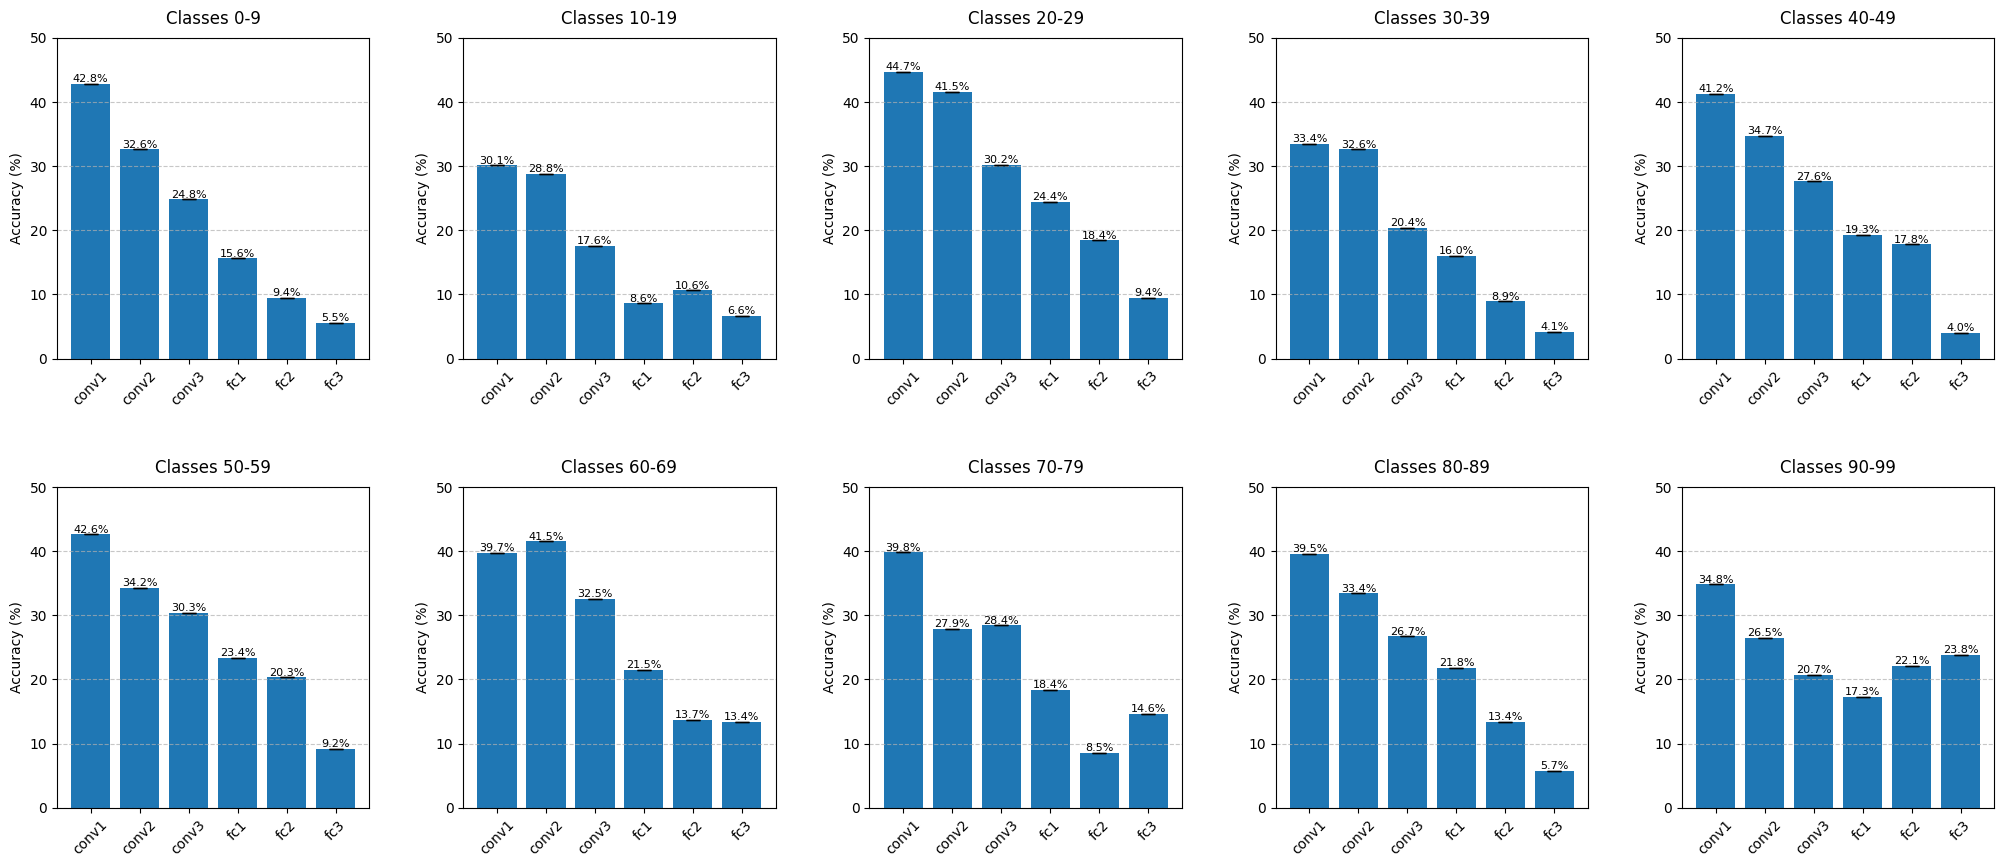

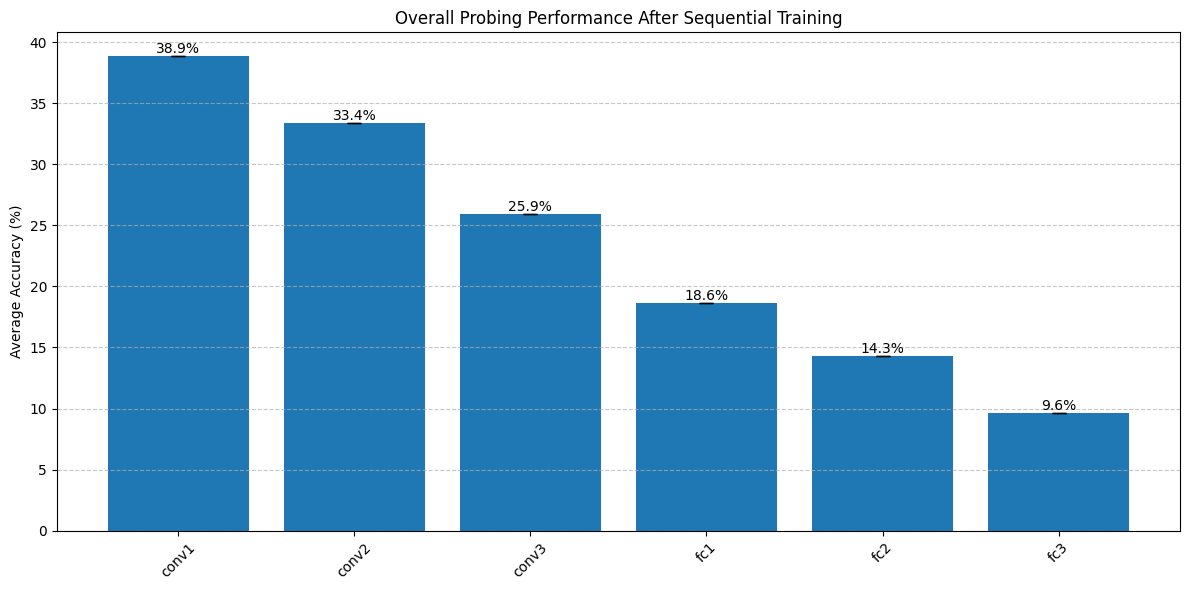

In [43]:
# Run as many times as needed to adjust visualization:
visualize_probing_results(probe_results, per_class_results, tasks, freeze_points, num_seeds)